In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, Add, LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
import tensorflow as tf

# --- Load all sensor data and stack into 3D array (samples, timesteps, features) ---

def load_sensor_data(base_path, sensor_name):
    # sensor_name e.g. 'body_acc_x_train.txt'
    df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
    return df.values

base_path = r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\Inertial Signals\\"

# Load all 9 sensor axes
body_acc_x = load_sensor_data(base_path, 'body_acc_x_train.txt')
body_acc_y = load_sensor_data(base_path, 'body_acc_y_train.txt')
body_acc_z = load_sensor_data(base_path, 'body_acc_z_train.txt')

body_gyro_x = load_sensor_data(base_path, 'body_gyro_x_train.txt')
body_gyro_y = load_sensor_data(base_path, 'body_gyro_y_train.txt')
body_gyro_z = load_sensor_data(base_path, 'body_gyro_z_train.txt')

total_acc_x = load_sensor_data(base_path, 'total_acc_x_train.txt')
total_acc_y = load_sensor_data(base_path, 'total_acc_y_train.txt')
total_acc_z = load_sensor_data(base_path, 'total_acc_z_train.txt')

# Stack all 9 axes into (samples, timesteps, features=9)
# Each input file shape: (7352, 128) -- 7352 samples, 128 time steps each
X = np.stack([
    body_acc_x, body_acc_y, body_acc_z,
    body_gyro_x, body_gyro_y, body_gyro_z,
    total_acc_x, total_acc_y, total_acc_z
], axis=2)  # shape: (7352, 128, 9)

print("X shape:", X.shape)

# Load labels
y = pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\y_train.txt", delim_whitespace=True, header=None).values.flatten()

# --- Standardize data per feature (flatten first) ---
nsamples, ntimesteps, nfeatures = X.shape
X_reshaped = X.reshape(-1, nfeatures)  # shape (7352*128, 9)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)

X_scaled = X_scaled.reshape(nsamples, ntimesteps, nfeatures)

# Encode labels to 0-based integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Labels:", np.unique(y_encoded))




C:\Users\MSI\AppData\Local\Temp\ipykernel_10520\669504868.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_10520\669504868.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_10520\669504868.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_10520\669504868.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated

X shape: (7352, 128, 9)


C:\Users\MSI\AppData\Local\Temp\ipykernel_10520\669504868.py:45: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y = pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\train\y_train.txt", delim_whitespace=True, header=None).values.flatten()


Labels: [0 1 2 3 4 5]


In [61]:
from tensorflow.keras.layers import Layer  # type: ignore
import tensorflow.keras.backend as K  # type: ignore

class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

    def get_config(self):
        config = super(Attention, self).get_config()
        return config


In [65]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(alpha, gamma=2.0):
    alpha = tf.constant(alpha, dtype=tf.float32)
    
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0 - K.epsilon())
        
        # Convert y_true to one-hot if needed
        y_true_onehot = tf.one_hot(y_true, depth=len(alpha))
        
        # Gather alpha for each true class
        alpha_t = tf.reduce_sum(alpha * y_true_onehot, axis=1)
        
        # Compute cross-entropy
        ce = -tf.reduce_sum(y_true_onehot * tf.math.log(y_pred), axis=1)
        
        # Compute focal loss modulating factor
        p_t = tf.reduce_sum(y_true_onehot * y_pred, axis=1)
        focal_factor = tf.pow(1 - p_t, gamma)
        
        loss = alpha_t * focal_factor * ce
        
        return tf.reduce_mean(loss)
    
    return focal_loss_fixed


In [66]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, SpatialDropout1D
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_improved_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # First Conv Block
    x = Conv1D(64, kernel_size=5, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.2)(x)

    # Second Conv Block (deeper filters)
    x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(0.2)(x)

    # LSTM Layer
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.3)(x)

    # Attention or GlobalPooling
    # x = Attention()(x)  # Optional: test both
    x = Attention()(x) 

    # Fully connected
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    alpha = [1.0, 1.0, 1.0, 4.0, 4.0, 1.0]  # Adjust weights for classes 4 and 5
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss=focal_loss(gamma=2., alpha=alpha), metrics=['accuracy'])
    return model


You must install pydot (`pip install pydot`) for `plot_model` to work.
Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.6152 - loss: 1.1014 - val_accuracy: 0.2610 - val_loss: 1.6496 - learning_rate: 0.0010
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9036 - loss: 0.2350 - val_accuracy: 0.2889 - val_loss: 1.9313 - learning_rate: 0.0010
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9348 - loss: 0.1756 - val_accuracy: 0.6866 - val_loss: 0.7568 - learning_rate: 0.0010
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.9367 - loss: 0.1784 - val_accuracy: 0.9205 - val_loss: 0.1415 - learning_rate: 0.0010
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.9411 - loss: 0.1543 - val_accuracy: 0.9436 - val_loss: 0.1234 - learning_rate: 0.0010
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.9414 - loss: 0.1598 - val_accuracy: 0.9579 - val_loss: 0.1046 - learning_rate: 0.0010
Epoch 7/50
92/92 ━━━━

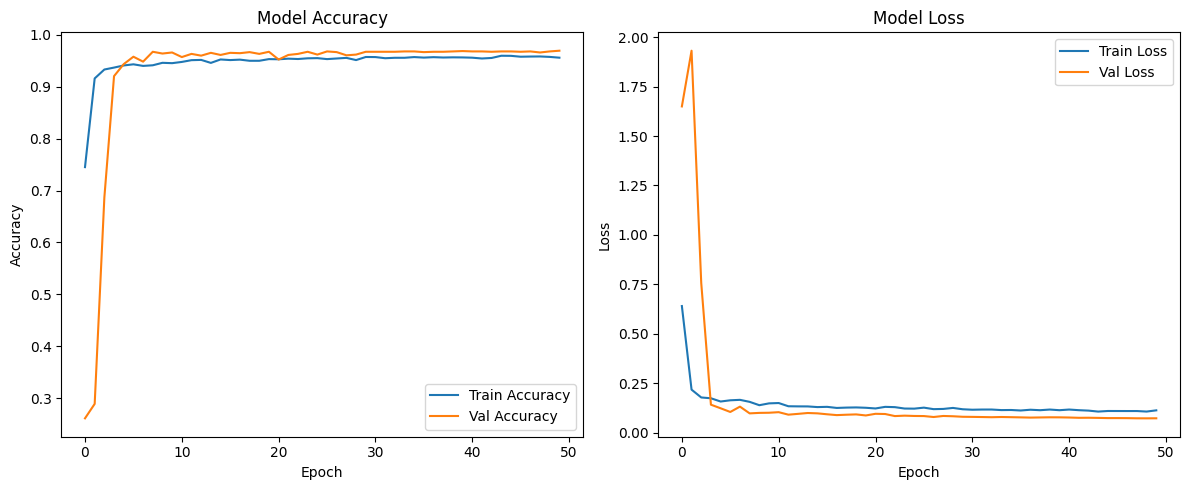

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

🧾 Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       245
           2       1.00      1.00      1.00       215
           3       1.00      1.00      1.00       197
           4       0.89      0.93      0.91       257
           5       0.94      0.89      0.91       275
           6       1.00      1.00      1.00       282

    accuracy                           0.97      1471
   macro avg       0.97      0.97      0.97      1471
weighted avg       0.97      0.97      0.97      1471



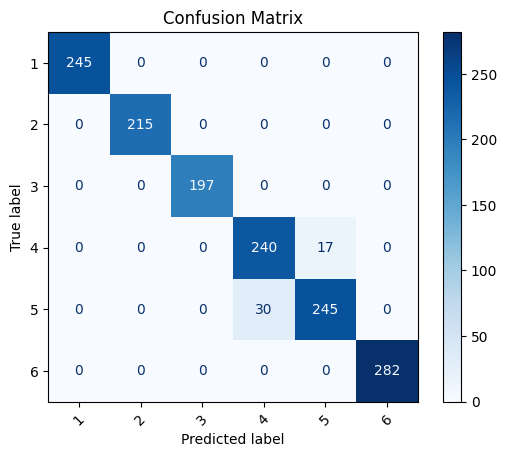

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

# --- Split the data ---
# Assuming your full preprocessed dataset is X and y
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded  # Preserves class distribution
)

# Compute balanced weights first
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

# Manually boost weights for class 4 and 5
class_weight_dict[4] *= 1.5
class_weight_dict[5] *= 1.5


# --- Build the model ---
model = build_improved_model(input_shape=(ntimesteps, nfeatures), num_classes=len(np.unique(y_train)))

# Optional: Save model architecture as image
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_architecture.png')

# --- Callbacks ---
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# --- Train the model ---
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# --- Plot training history ---
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

# --- Predictions and Evaluation ---
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print("\n🧾 Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_.astype(str)))

# --- Confusion Matrix ---
cm = confusion_matrix(y_val, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()


In [77]:
model.save(r'C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\Models\CNN_LSTM_AttentionC.h5')

In [72]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 128, 64)        │         2,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 128, 64)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_16 (Conv1D)              │ (None, 128, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 128, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,880 (530.79 KB)

 Trainable params: 135,494 (529.27 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 2 (12.00 B)

In [80]:
from tensorflow.keras.models import load_model # type: ignore
model = load_model(
    r'C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\Models\CNN_LSTM_AttentionC.h5',
    custom_objects={'Attention': Attention}
)


C:\Users\MSI\AppData\Local\Temp\ipykernel_10520\3896586780.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_10520\3896586780.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_10520\3896586780.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
C:\Users\MSI\AppData\Local\Temp\ipykernel_10520\3896586780.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprec

X_test shape: (2947, 128, 9)
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Accuracy: 0.9321343739395996

Classification Report:

              precision    recall  f1-score   support

           1       1.00      0.99      0.99       496
           2       0.99      1.00      0.99       471
           3       0.98      1.00      0.99       420
           4       0.79      0.83      0.81       491
           5       0.85      0.80      0.82       532
           6       0.99      1.00      1.00       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



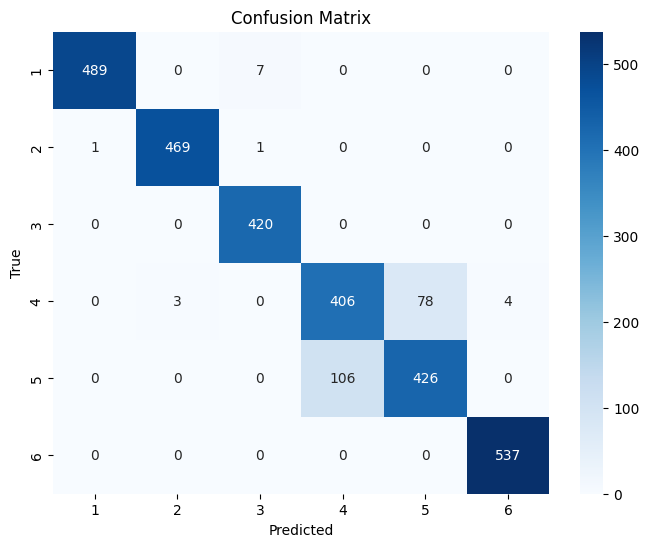

In [81]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load test sensor signal data from UCI HAR Dataset ---
def load_sensor_data(base_path, sensor_name):
    df = pd.read_csv(base_path + sensor_name, delim_whitespace=True, header=None)
    return df.values

# Use the TEST path, not TRAIN
base_path = r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\test\Inertial Signals\\"

# Load all 9 sensor axes
body_acc_x = load_sensor_data(base_path, 'body_acc_x_test.txt')
body_acc_y = load_sensor_data(base_path, 'body_acc_y_test.txt')
body_acc_z = load_sensor_data(base_path, 'body_acc_z_test.txt')

body_gyro_x = load_sensor_data(base_path, 'body_gyro_x_test.txt')
body_gyro_y = load_sensor_data(base_path, 'body_gyro_y_test.txt')
body_gyro_z = load_sensor_data(base_path, 'body_gyro_z_test.txt')

total_acc_x = load_sensor_data(base_path, 'total_acc_x_test.txt')
total_acc_y = load_sensor_data(base_path, 'total_acc_y_test.txt')
total_acc_z = load_sensor_data(base_path, 'total_acc_z_test.txt')

# Stack all 9 axes into shape: (samples, timesteps, features=9)
X_test = np.stack([
    body_acc_x, body_acc_y, body_acc_z,
    body_gyro_x, body_gyro_y, body_gyro_z,
    total_acc_x, total_acc_y, total_acc_z
], axis=2)

print("X_test shape:", X_test.shape)  # should be (2947, 128, 9)

# --- Load test labels ---
y_test = pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\UCI HAR Dataset\test\y_test.txt", delim_whitespace=True, header=None).values.flatten()

# --- Standardize data ---
nsamples, ntimesteps, nfeatures = X_test.shape
X_test_reshaped = X_test.reshape(-1, nfeatures)  # shape: (2947*128, 9)

scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test_reshaped)

X_test_scaled = X_test_reshaped.reshape(nsamples, ntimesteps, nfeatures)

# --- Label encode y_test ---
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(y_test)




# --- Predict ---
y_pred_probs = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# --- Evaluate ---
# === Evaluate ===
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_classes))
print("\nClassification Report:\n")
# Convert class labels to string if they are integers
target_names = [str(cls) for cls in label_encoder.classes_]
print(classification_report(y_test_encoded, y_pred_classes, target_names=target_names))

# --- Confusion matrix ---
cm = confusion_matrix(y_test_encoded, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
